In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from sklearn.pipeline import Pipeline
# import pickle
from sklearn.externals import joblib

In [3]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                imag = cv2.imread(imgFile, 0)
                if cv2.countNonZero(imag) <= 500:
                    pass
                else:
                    img = plt.imread(imgFile)
                    # The image array is a multidimensional numpy array
                    # - flatten it to a single array of pixel values for scikit-learn
                    # - and add it to the list of features
                    features.append(img.ravel())

                    # Add it to the numpy array of labels
                    labels = np.append(labels, class_id )
            class_id  += 1
            
    # convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

In [4]:
#the images are in a folder named 'plantnetSimplon/training_data_/training'
training_folder_name = "../plantnetSimplon/training_data_/training"

In [5]:
# prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

Reading data from Cichorium_intybus_L
Reading data from Leucanthemum_vulgare_(Vaill)_Lam
Reading data from Malva_sylvestris_L
Reading data from Papaver_rhoeas_L
Reading data from Ranunculus_bulbosus_L
3429 features
3429 labels
5 classes: ['Cichorium_intybus_L', 'Leucanthemum_vulgare_(Vaill)_Lam', 'Malva_sylvestris_L', 'Papaver_rhoeas_L', 'Ranunculus_bulbosus_L']


In [6]:
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Feature Shape: (3429, 67500)
Labels Shape: (3429,)


In [7]:
# split into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.30, random_state=42)

print('Training records:',y_train.size)
print('Validation records:',y_val.size)

Training records: 2400
Validation records: 1029


In [11]:
# standardize features by removing the mean and scaling to unit variance
X_train_float = X_train.astype('float64')
X_val_float = X_val.astype('float64')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_float)
X_val_scaled = scaler.fit_transform(X_val_float)

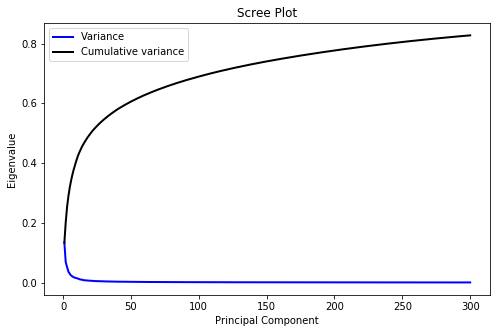

In [82]:
pca = PCA(n_components=300, svd_solver='randomized',
          whiten=True).fit(X_train_scaled)

pca_var = pca.explained_variance_ratio_
pca_var_sum = np.cumsum(pca.explained_variance_ratio_)
pcas = list(range(1, 301, 1))

plt.figure(figsize=(8,5))
plt.plot(pcas, pca_var, 'b-', linewidth=2, label = 'Variance')
plt.plot(pcas, pca_var_sum, 'k-', linewidth=2, label = 'Cumulative variance')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.legend()
plt.show()

In [45]:
def pca_cross_validation(X_train_scaled, y_train, n_components, predictor):        
    d = {"lr" :LogisticRegression(), 
         "rf":RandomForestClassifier(),
         "svc":SVC(),
         "knn":KNeighborsClassifier()}
    df = pd.DataFrame(index = n_components)
    # iterate over PCAs
    for component in n_components:
        pca = PCA(n_components=component, svd_solver='randomized',whiten=True)
        X_train_pca = pca.fit_transform(X_train_scaled)
        df.loc[component,'explained variance'] = round(pca.explained_variance_ratio_.sum(),3)
        # iterate over models for each PCA
        for col, model in d.items():
            cv_scores = cross_val_score(model, X_train_pca, y_train, cv=3, n_jobs = -1)
            df.loc[component,'_'.join([col, 'mean'])] = round(cv_scores.mean(),3)
            df.loc[component,'_'.join([col, 'std'])] =  round(cv_scores.std(),3)

    return df

In [46]:
# compare the cross-validation scores for different number of PCA components
n_components = [100, 150, 200, 250, 300]
predictor = [LogisticRegression(), RandomForestClassifier(), SVC(), KNeighborsClassifier()]

pca_cross_validation(X_train_scaled, y_train, n_components, predictor)

,explained variance,lr_mean,lr_std,rf_mean,rf_std,svc_mean,svc_std,knn_mean,knn_std
100,0.689,0.836,0.012,0.700,0.014,0.738,0.023,0.571,0.014
150,0.740,0.805,0.007,0.674,0.017,0.707,0.014,0.547,0.014
200,0.776,0.768,0.011,0.677,0.009,0.668,0.007,0.528,0.017
250,0.804,0.751,0.006,0.655,0.011,0.650,0.011,0.495,0.012
300,0.827,0.713,0.007,0.644,0.018,0.624,0.016,0.474,0.018


In [47]:
# the optimal choice is the PCA with 150 components 
pca = PCA(n_components=150, svd_solver='randomized',
          whiten=True).fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [48]:
def fine_tune_predictor(predictor, grid):
    predictor_cv = GridSearchCV(predictor, grid, cv=3)
    predictor_cv.fit(X_train_pca, y_train)
    print("Tuned hpyerparameters :(best parameters) ", predictor_cv.best_params_)
    print("Accuracy :",predictor_cv.best_score_)

In [49]:
parameters_svm = {'C':[1, 10, 100], 'gamma':[0.0001, 0.001, 0.01, 0.1,'auto']}

parameters_rf = {'n_estimators': [10, 50, 100], 'min_samples_leaf': [2,4], 'min_samples_split':[2,6], 'max_depth': [10, 50, 100]}

parameters_lr = {'penalty': ['l1', 'l2'],'C':[0.001,0.01,1,10], 'solver':['liblinear', 'saga']}

In [50]:
fine_tune_predictor(SVC(), parameters_svm)

Tuned hpyerparameters :(best parameters)  {'C': 10, 'gamma': 0.001}
Accuracy : 0.7579166666666667


In [51]:
fine_tune_predictor(RandomForestClassifier(n_jobs = -1), parameters_rf)

Tuned hpyerparameters :(best parameters)  {'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy : 0.6924999999999999


In [53]:
fine_tune_predictor(LogisticRegression(max_iter=10000), parameters_lr)

Tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Accuracy : 0.8491666666666666


In [66]:
svc_clf = SVC(C=10, gamma=0.001, kernel='rbf', probability=True, random_state=42)
lr_clf = LogisticRegression(max_iter=10000, C=1, penalty='l1', solver='saga', random_state=42)
rf_clf = RandomForestClassifier(n_jobs = -1, max_depth=100, min_samples_leaf=2,
                                          min_samples_split=2, n_estimators=100, random_state=42)
voting_clf = VotingClassifier(estimators=[('lr', lr_clf), ('svc', svc_clf)], voting='soft')
stacking_clf = StackingClassifier(estimators=[('lr', lr_clf), ('svc', svc_clf)])

In [67]:
# comparing the accuracy of individual estimators and ensemble models
for clf in (lr_clf, svc_clf, rf_clf, voting_clf, stacking_clf):
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_val_pca)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.8726919339164237
SVC 0.8202137998056366
RandomForestClassifier 0.6977648202137998
VotingClassifier 0.8785228377065112
StackingClassifier 0.8726919339164237


In [19]:
# put everything together in the pipeline
steps = [('scl', StandardScaler()), 
         ('pca', PCA(n_components=150, svd_solver='randomized',whiten=True)), 
         ('voting_clf', VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=10000,C=1, 
                                                                               penalty='l1',solver='saga', random_state=42)), 
                                                     ('svc', SVC(C=10, gamma=0.001, kernel='rbf', probability=True, 
                                                                 random_state=42))], voting='soft'))]

pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=150,
                     random_state=None, svd_solver='randomized', tol=0.0,
                     whiten=True)),
                ('voting_clf',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=1,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_scali...
                                                                  solver='saga',
                                                                  tol=0.0001,
                       

In [ ]:
# serialize the pipeline
joblib.dump(pipe, 'pipeline_model.joblib')

In [20]:
# make predictions
y_pred = pipe.predict(X_val)

In [21]:
print(classification_report(y_val, y_pred, target_names=classnames))

                                  precision    recall  f1-score   support

             Cichorium_intybus_L       0.93      0.88      0.90       237
Leucanthemum_vulgare_(Vaill)_Lam       0.85      0.86      0.85       210
              Malva_sylvestris_L       0.84      0.90      0.87       210
                Papaver_rhoeas_L       0.98      0.90      0.94       201
           Ranunculus_bulbosus_L       0.84      0.90      0.87       171

                        accuracy                           0.89      1029
                       macro avg       0.89      0.89      0.89      1029
                    weighted avg       0.89      0.89      0.89      1029



In [22]:
confusion_matrix(y_val, y_pred)

array([[208,   7,  18,   0,   4],
       [  8, 180,   4,   0,  18],
       [  6,   8, 189,   2,   5],
       [  0,   4,  14, 181,   2],
       [  2,  13,   1,   1, 154]], dtype=int64)

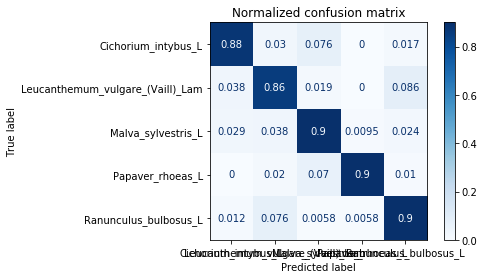

In [24]:
disp = plot_confusion_matrix(pipe, X_val, y_val,
                             display_labels=classnames,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
plt.show()

In [27]:
def multiclass_roc_auc_score(y_val, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_val)
    y_val_b = lb.transform(y_val)
    y_pred_b = lb.transform(y_pred)
    return roc_auc_score(y_val_b, y_pred_b, average=average)

In [28]:
# evaluate the AUC ROC score
multiclass_roc_auc_score(y_val, y_pred)

0.9293988469047558